<a href="https://www.kaggle.com/code/noahnguyen08/customer-churn-classification-and-network-analysis?scriptVersionId=164633099" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/customer-churn-data-infinite-investment-systems/account_data_info.csv
/kaggle/input/customer-churn-data-infinite-investment-systems/history.csv
/kaggle/input/customer-churn-data-infinite-investment-systems/test.csv


In [2]:
!pip install kmodes
!pip install networkx
!pip install prince

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import prince                 # MCA

import datetime
import category_encoders as ce

from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from kmodes.kmodes import KModes
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.metrics import roc_curve, auc

from PIL import Image

# from kneed import KneeLocator
%matplotlib inline

## Loading data

In [4]:
df = pd.read_csv("/kaggle/input/customer-churn-data-infinite-investment-systems/history.csv")
test = pd.read_csv("/kaggle/input/customer-churn-data-infinite-investment-systems/test.csv")

/tmp/ipykernel_1582/3662440966.py:1: DtypeWarning: Columns (87) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/kaggle/input/customer-churn-data-infinite-investment-systems/history.csv")
/tmp/ipykernel_1582/3662440966.py:2: DtypeWarning: Columns (62,64,87) have mixed types. Specify dtype option on import or set low_memory=False.
  test = pd.read_csv("/kaggle/input/customer-churn-data-infinite-investment-systems/test.csv")


In [5]:
data_info = pd.read_csv("/kaggle/input/customer-churn-data-infinite-investment-systems/account_data_info.csv", encoding = "latin-1")

In [6]:
df_copy = df[:]        # make a copy for customer churn data
test_copy = test[:]    # make a copy for test data

In [7]:
data_info_copy = data_info[:]

## Data Processing

Description of each feature

In [8]:
data_info_copy.head(10)

,Columns,Description,Field Values
0,type_code,Account Type,CSH - Cash/RSP (note: Registered accounts are ...
1,is_registered,NaN,MRL - Margin - Long
2,country_code,NaN,MRS - Margin - Short
3,currency_code,Currency of the Accoun,COD - Cash on Delivery
4,is_active,NaN,COM - Commodity
5,class_id,NaN,PSP - Prospect
6,credit_code,Interest rate charged for debit balance. ISM A...,NaN
7,debit_code,Debit Interest Method. An ISM ACF Code that de...,0 None\n 1 Normal\n [2-9] or [A-Z] (except I...
8,last_trade_date,Last trade date in the client's account - ISM ...,NaN
9,contract_type,Represents the shareholder information SHLDR 5...,07 -if OBO: Y and Mail S \n 09 -if NOBO: Y and...


### Dealing with missing values

There are missing data in the description of some features. We'd proceed imputing these missing values with an empty string.

In [9]:
data_info_copy['Description'] = data_info_copy['Description'].fillna(' ')   # imputing missing data with empty string
data_info_copy['Field Values'] = data_info_copy['Field Values'].fillna(' ')

In [10]:
data_info_copy['Columns'][1]

'is_registered'

In [11]:
data_info_copy.head(5)

,Columns,Description,Field Values
0,type_code,Account Type,CSH - Cash/RSP (note: Registered accounts are ...
1,is_registered,,MRL - Margin - Long
2,country_code,,MRS - Margin - Short
3,currency_code,Currency of the Accoun,COD - Cash on Delivery
4,is_active,,COM - Commodity


In [12]:
pd.set_option('display.max_columns', None)    # show all columns

In [13]:
df_copy.columns[0]

'id'

We observe that the number of columns in the data description and the customer data is not the same. We'd check what are the columns that don't exist in the customer data.

In [14]:
data_info_lst = []
customer_data_lst = []
for val in range(len(data_info_copy['Columns'])):
  data_info_lst.append(data_info_copy['Columns'][val])

for col in range(len(df_copy.columns)):
  customer_data_lst.append(df_copy.columns[col])

In [15]:
print(data_info_lst)

['type_code', 'is_registered', 'country_code', 'currency_code', 'is_active', 'class_id', 'credit_code', 'debit_code', 'last_trade_date', 'contract_type', 'inception_date', 'inception_date', 'net_of_fees', 'cashflows_custody_fee', 'fee_paid_separately', 'custody_fee_withdrawal', 'is_fee_exempt', 'branch', 'closing_date', 'closing_date', 'closure_reason', 'include_client_consolidation', 'use_client_address', 'credit_limit_type', 'retail_plan', 'is_spousal', 'is_arp_locked', 'arp_pension_origin', 'language_code', 'dividend_confirm_code', 'sss_location', 'options_trading_type', 'sss_type', 'sss_agent', 'is_midwest_clearing_account', 'rep_commission_rate', 'rep_commission_override', 'interest_dividend_conversion_type', 'guarantee_gtor_type', 'use_hand_delivery', 'use_mail', 'share_name_address_to_issuer', 'shareholder_instructions_received', 'rrsp_limit_reached', 'is_portfolio_account', 'has_no_min_commission', 'is_tms_eligible', 'is_agent_bbs_participant', 'is_parameters_account', 'is_spou

In [16]:
print(customer_data_lst)

['id', 'type_code', 'is_registered', 'country_code', 'currency_code', 'is_active', 'class_id', 'debit_code', 'last_trade_date', 'contract_type', 'inception_date', 'net_of_fees', 'cashflows_custody_fee', 'fee_paid_separately', 'custody_fee_withdrawal', 'is_fee_exempt', 'branch', 'include_client_consolidation', 'use_client_address', 'credit_limit_type', 'retail_plan', 'is_spousal', 'is_arp_locked', 'arp_pension_origin', 'language_code', 'dividend_confirm_code', 'sss_location', 'options_trading_type', 'sss_type', 'sss_agent', 'is_midwest_clearing_account', 'rep_commission_rate', 'rep_commission_override', 'interest_dividend_conversion_type', 'guarantee_gtor_type', 'use_hand_delivery', 'use_mail', 'share_name_address_to_issuer', 'shareholder_instructions_received', 'rrsp_limit_reached', 'is_portfolio_account', 'has_no_min_commission', 'is_tms_eligible', 'is_agent_bbs_participant', 'is_parameters_account', 'is_spousal_transfer', 'spousal_age_flag', 'terminal_code', 'has_multiple_name', 'dec

In [17]:
info_DNE = []
for i in range(len(data_info_lst)):
  if data_info_lst[i] not in customer_data_lst:
    info_DNE.append(data_info_lst[i])

In [18]:
info_DNE

['credit_code', 'closing_date', 'closing_date', 'closure_reason']

These are the columns that didn't appear on the customer data.

In [19]:
df_copy['country_code'].isnull().value_counts()

country_code
True     669050
False      4289
Name: count, dtype: int64

In [20]:
df_copy['currency_code'].isnull().value_counts()

currency_code
False    673339
Name: count, dtype: int64

`country_code` and `currency_code` have the same purpose, let's say your currency code is CAD, it's likely that you are from Canada, thus the `country_code` may not contribute any useful information. Thus we'd drop this column.

In [21]:
df_copy = df_copy.drop('country_code', axis=1)

In [22]:
df_copy['cashflows_custody_fee'].isnull().value_counts()

cashflows_custody_fee
True    673339
Name: count, dtype: int64

As all the records in `cashflows_custody_fee` are missing, we'd just drop this column as well.

In [23]:
df_copy = df_copy.drop('cashflows_custody_fee', axis=1)

In [24]:
df_copy['esir_number'].isnull().value_counts()

esir_number
True     673327
False        12
Name: count, dtype: int64

In [25]:
df_copy = df_copy.drop('esir_number', axis=1)

In [26]:
def missing_data_per_col(data):
  '''
    Show the number of missing values
    in each column

    input: data
  '''
  null_count = []
  missing_data = {}
  for col in data.columns:
    missing_data[col] = [data[col].isna().sum()]
  missing_df = pd.DataFrame(missing_data)
  missing_df = missing_df.rename(columns = {0: "Number of missing values"})
  return missing_df


In [27]:
missing_data_df = missing_data_per_col(df_copy)

In [28]:
missing_data_df

,id,type_code,is_registered,currency_code,is_active,class_id,debit_code,last_trade_date,contract_type,inception_date,net_of_fees,fee_paid_separately,custody_fee_withdrawal,is_fee_exempt,branch,include_client_consolidation,use_client_address,credit_limit_type,retail_plan,is_spousal,is_arp_locked,arp_pension_origin,language_code,dividend_confirm_code,sss_location,options_trading_type,sss_type,sss_agent,is_midwest_clearing_account,rep_commission_rate,rep_commission_override,interest_dividend_conversion_type,guarantee_gtor_type,use_hand_delivery,use_mail,share_name_address_to_issuer,shareholder_instructions_received,rrsp_limit_reached,is_portfolio_account,has_no_min_commission,is_tms_eligible,is_agent_bbs_participant,is_parameters_account,is_spousal_transfer,spousal_age_flag,terminal_code,has_multiple_name,deceased_fair_market_value,target_grantor_grantee_flag,discretionary_trading_authorized,iso_funds_code,shareholder_language,dup_trip_quad_code,special_tag,conjunction,title,function_code,tms_settlement_location,portfolio_cost_method,portfolio_name_address_option,portfolio_report_option,portfolio_summary_option,receive_general_mailings,loan_limit_override,interactive_portfolio_code,non_plan_book_value_flag,has_discrete_auth,last_update_date,is_non_objecting_beneficial_owner,is_objecting_to_disclose_info,mailing_consent,consent_to_pay_for_mail,consent_to_email_delivery,has_received_instruction,risk_tolerance,investment_objective,is_broker_account,is_inventory_account,is_gl_account,is_control_account,is_extract_eligible,last_maintenance_time,last_maintenance_user,is_pledged,special_fee_code,non_calendar_year_end,plan_effective_date,plan_end_date,is_resp,number_of_beneficiaries,rrif_original_date,use_original_date_for_payment_calc,is_family_resp,is_hrdc_resp,is_plan_grandfathered,resp_specimen_plan,inserted_at,updated_at,is_olob,retail_last_maintenance_time,retail_last_maintenance_user,visible_in_reports,label
0,0,237,0,0,0,3198,3198,307875,95823,3198,0,0,0,0,3198,0,0,3198,316985,313694,313694,632725,3198,3198,668258,3198,668258,668273,3198,3198,3198,3198,3198,0,0,0,0,0,0,0,0,0,0,0,0,77413,0,3198,504876,76123,3198,623554,3210,626904,657891,186266,669102,665590,3198,3198,3198,3198,0,642194,3198,368978,96045,111327,0,0,3198,0,0,0,145530,145453,0,0,0,0,0,3538,3198,316985,673271,316985,316985,517718,316985,316985,316985,316985,316985,316985,316985,650618,0,0,0,316985,317118,0,0


In [29]:
len(missing_data_df.columns)

103

### Analyzing the contribution of each feature

#### Categorical features that have too many categories -> K-modes clustering

In [30]:
print("Number of categories in class_id: ", len(df_copy['class_id'].unique()))
print("Number of categories in terminal_code: ", len(df_copy['terminal_code'].unique()))
print("Number of categories in sss_agent: ", len(df_copy['sss_agent'].unique()))
print("Number of categories in deceased_fair_market_value: ", len(df_copy['deceased_fair_market_value'].unique()))
print("Number of categories in risk_tolerance: ", len(df_copy['risk_tolerance'].unique()))
print("Number of categories in investment_objective: ", len(df_copy['investment_objective'].unique()))
print("Number of categories in last_maintenance_user: ", len(df_copy['last_maintenance_user'].unique()))
print("Number of categories in special_fee_code: ", len(df_copy['special_fee_code'].unique()))
print("Number of categories in retail_last_maintenance_user: ", len(df_copy['retail_last_maintenance_user'].unique()))
print(len(df_copy['retail_last_maintenance_user'].unique()))

Number of categories in class_id:  66
Number of categories in terminal_code:  1439
Number of categories in sss_agent:  3816
Number of categories in deceased_fair_market_value:  2126
Number of categories in risk_tolerance:  848
Number of categories in investment_objective:  1472
Number of categories in last_maintenance_user:  445
Number of categories in special_fee_code:  36
Number of categories in retail_last_maintenance_user:  433
433


Drop `rep_commission_rate`, `dup_trip_quad_code`, `portfolio_cost_method`, `portfolio_name_address_option` columns as they only have one single value.

In [31]:
# df_copy = df_copy.drop('rep_commission_rate', axis=1)
# df_copy = df_copy.drop('dup_trip_quad_code', axis=1)
# df_copy = df_copy.drop('portfolio_cost_method', axis=1)
# df_copy = df_copy.drop('portfolio_name_address_option', axis=1)
# df_copy = df_copy.drop('portfolio_summary_option', axis=1)
# df_copy = df_copy.drop('interactive_portfolio_code', axis=1)
# df_copy = df_copy.drop('non_plan_book_value_flag', axis=1)

In [32]:
df_copy

,id,type_code,is_registered,currency_code,is_active,class_id,debit_code,last_trade_date,contract_type,inception_date,net_of_fees,fee_paid_separately,custody_fee_withdrawal,is_fee_exempt,branch,include_client_consolidation,use_client_address,credit_limit_type,retail_plan,is_spousal,is_arp_locked,arp_pension_origin,language_code,dividend_confirm_code,sss_location,options_trading_type,sss_type,sss_agent,is_midwest_clearing_account,rep_commission_rate,rep_commission_override,interest_dividend_conversion_type,guarantee_gtor_type,use_hand_delivery,use_mail,share_name_address_to_issuer,shareholder_instructions_received,rrsp_limit_reached,is_portfolio_account,has_no_min_commission,is_tms_eligible,is_agent_bbs_participant,is_parameters_account,is_spousal_transfer,spousal_age_flag,terminal_code,has_multiple_name,deceased_fair_market_value,target_grantor_grantee_flag,discretionary_trading_authorized,iso_funds_code,shareholder_language,dup_trip_quad_code,special_tag,conjunction,title,function_code,tms_settlement_location,portfolio_cost_method,portfolio_name_address_option,portfolio_report_option,portfolio_summary_option,receive_general_mailings,loan_limit_override,interactive_portfolio_code,non_plan_book_value_flag,has_discrete_auth,last_update_date,is_non_objecting_beneficial_owner,is_objecting_to_disclose_info,mailing_consent,consent_to_pay_for_mail,consent_to_email_delivery,has_received_instruction,risk_tolerance,investment_objective,is_broker_account,is_inventory_account,is_gl_account,is_control_account,is_extract_eligible,last_maintenance_time,last_maintenance_user,is_pledged,special_fee_code,non_calendar_year_end,plan_effective_date,plan_end_date,is_resp,number_of_beneficiaries,rrif_original_date,use_original_date_for_payment_calc,is_family_resp,is_hrdc_resp,is_plan_grandfathered,resp_specimen_plan,inserted_at,updated_at,is_olob,retail_last_maintenance_time,retail_last_maintenance_user,visible_in_reports,label
0,893724,CASH SWEEP,f,CAD,t,3.0,0,NaN,NaN,2017-08-18,f,f,f,f,IAVM,t,f,0.0,NaN,NaN,NaN,NaN,E,0.0,NaN,0.0,NaN,NaN,False,0.0,0.0,0.0,0.0,f,f,t,f,f,f,f,f,f,f,f,f,NaN,f,0.0,NaN,f,CAD,NaN,A,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,t,NaN,0.0,V,f,NaN,f,f,0.0,f,f,f,NaN,NaN,f,f,f,f,t,2021-12-16 00:00:00,T80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-05-30 14:20:18.531115+00,2023-08-08 18:53:01.439561+00,f,NaN,NaN,f,Churn
1,1268094,RRIF,t,CAD,t,5.0,C,2022-07-04,18.0,2018-11-08,f,f,f,f,IAVM,t,t,0.0,RI,f,f,NaN,E,0.0,NaN,0.0,NaN,NaN,False,0.0,0.0,0.0,2.0,f,f,t,f,f,f,f,f,f,f,f,f,BATCH,f,0.0,NaN,f,CAD,NaN,A,NaN,NaN,MR,NaN,NaN,0.0,0.0,0.0,0.0,t,NaN,0.0,NaN,f,2022-09-08,t,f,0.0,f,f,t,H10M90,B05G85S10,f,f,f,f,t,2023-01-03 00:00:00,BATCH,f,NaN,0000,2018-11-08,NaN,f,0.0,2018-11-08,f,f,f,f,NaN,2023-05-30 14:20:18.531115+00,2023-08-10 21:47:25.370403+00,f,2023-01-03 00:00:00,BATCH,t,Churn
2,606613,SPOUSAL RRSP,t,CAD,t,5.0,A,2018-07-05,16.0,2009-04-08,f,f,f,f,IAVM,f,f,0.0,RS,t,f,NaN,F,0.0,NaN,0.0,NaN,NaN,False,0.0,0.0,0.0,2.0,f,f,t,f,f,f,f,f,f,f,f,f,G023,f,0.0,NaN,f,CAD,F,A,NaN,NaN,MADAME,NaN,NaN,0.0,0.0,0.0,0.0,t,NaN,0.0,NaN,f,2014-04-23,f,t,0.0,t,f,t,H50M50S00,G50S50,f,f,f,f,t,2021-03-15 00:00:00,GUERINO,f,NaN,00/0,2009-04-08,2018-07-17,f,0.0,2009-04-08,f,f,f,f,NaN,2023-05-30 14:20:18.531115+00,2023-08-10 21:47:25.370403+00,f,2018-07-17 00:00:00,GUERINO,f,Churn
3,741930,CASH,f,CAD,t,3.0,T,NaN,12.0,2021-01-04,f,f,f,f,IAVM,t,t,0.0,NaN,NaN,NaN,NaN,E,0.0,NaN,0.0,NaN,NaN,False,0.0,0.0,0.0,0.0,f,f,t,f,f,f,f,f,f,f,f,f,113C,f,0.0,NaN,f,CAD,NaN,A,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,t,NaN,0.0,V,f,2021-01-04,t,f,0.0,f,f,t,M99,G99,f,f,f,f,t,2021-01-04 00:00:00,T80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-05-30 14:20:18.531115+00,2023-08-08 18:53:01.439561+00,f,NaN,NaN,t,Churn
4,1137922,CASH,f,CAD,t,3.0,T,NaN,17.0,2017-07-21,f,f,f,f,IAVM,t,f,0.0,NaN,NaN,NaN,NaN,E,0.0,NaN,0.0,NaN,NaN,False,0.0,0.0,0.0,0.0,f,f,t,f,f,f,f,f,f,f,f,f,BATCH,f,0.0,NaN,f,CAD,NaN,A,NaN,NaN,MRS,NaN,NaN,0.0,0.0,0.0,0.0,t,NaN,0.0,V,NaN,2017-07-24,f,t,0.0,f,f,t,M99,G

In [33]:
df_copy_time_based_cols = df_copy[['inception_date', 'last_update_date', 'last_maintenance_time', 'rrif_original_date', 'plan_effective_date', 'plan_end_date', 'last_trade_date', 'inserted_at', 'updated_at', 'retail_last_maintenance_time']]
# for time-based columns, create dummy variables -> year, month, day and convert them to int dtype


df_copy_bool_based_cols = df_copy[['is_registered', 'is_active', 'net_of_fees', 'fee_paid_separately', 'custody_fee_withdrawal', 'is_fee_exempt', 'include_client_consolidation', 'use_client_address',
                                   'is_spousal', 'is_arp_locked', 'is_midwest_clearing_account', 'use_hand_delivery', 'use_mail', 'share_name_address_to_issuer', 'shareholder_instructions_received',
                                   'rrsp_limit_reached', 'is_portfolio_account', 'has_no_min_commission', 'is_tms_eligible', 'is_agent_bbs_participant', 'is_parameters_account', 'is_spousal_transfer',
                                   'spousal_age_flag', 'has_multiple_name', 'discretionary_trading_authorized', 'receive_general_mailings', 'has_discrete_auth', 'is_non_objecting_beneficial_owner',
                                   'is_objecting_to_disclose_info', 'consent_to_pay_for_mail', 'consent_to_email_delivery', 'has_received_instruction', 'is_broker_account', 'is_inventory_account',
                                   'is_gl_account', 'is_control_account', 'is_extract_eligible', 'is_pledged', 'is_resp', 'use_original_date_for_payment_calc', 'is_family_resp', 'is_hrdc_resp',
                                   'is_plan_grandfathered', 'is_olob', 'visible_in_reports']]

# for bool-based columns, convert to binary (0 and 1)

df_copy_categorical_based_cols = df_copy[['type_code', 'currency_code', 'class_id', 'debit_code', 'contract_type', 'branch', 'credit_limit_type', 'retail_plan', 'arp_pension_origin', 'language_code', 'dividend_confirm_code',
                                          'sss_location', 'options_trading_type', 'sss_type', 'sss_agent', 'rep_commission_override', 'interest_dividend_conversion_type', 'guarantee_gtor_type', 'terminal_code',
                                          'deceased_fair_market_value', 'target_grantor_grantee_flag', 'iso_funds_code', 'shareholder_language', 'special_tag', 'conjunction', 'title', 'function_code', 'tms_settlement_location',
                                          'portfolio_report_option', 'loan_limit_override', 'mailing_consent', 'risk_tolerance', 'investment_objective', 'last_maintenance_user', 'special_fee_code', 'non_calendar_year_end',
                                          'number_of_beneficiaries', 'resp_specimen_plan', 'retail_last_maintenance_user']]

# for categorical-based columns, perform clustering (for features that contain a lot of categories)

# the number of clusters will be decided by elbow method (or domain knowledge)

Check if there is any missing columns after assigning columns into variables

In [34]:
count_missing_col = 0
for i in range(len(df_copy_time_based_cols.columns)):
  if df_copy_time_based_cols.columns[i] not in df_copy.columns:
    count_missing_col += 1

for i in range(len(df_copy_bool_based_cols.columns)):
  if df_copy_bool_based_cols.columns[i] not in df_copy.columns:
    count_missing_col += 1

for i in range(len(df_copy_categorical_based_cols.columns)):
  if df_copy_categorical_based_cols.columns[i] not in df_copy.columns:
    count_missing_col += 1
print(count_missing_col)

0


#### Check the null values in each feature

In [35]:
nan_count = df_copy.isna().sum()

In [36]:
nan_count.sort_values(axis=0).value_counts().sort_index()

0         39
237        1
3198      22
3210       1
3538       1
76123      1
77413      1
95823      1
96045      1
111327     1
145453     1
145530     1
186266     1
307875     1
313694     2
316985    12
317118     1
368978     1
504876     1
517718     1
623554     1
626904     1
632725     1
642194     1
650618     1
657891     1
665590     1
668258     2
668273     1
669102     1
673271     1
Name: count, dtype: int64

We observe that there are 39 columns that contain no missing values. We will perform clustering on those columns

In [37]:
no_nan_cols = df_copy[list(nan_count[nan_count == 0].index)]

We have to drop the target variable (label: churn or no churn)

In [38]:
no_nan_cols = no_nan_cols.drop('label', axis=1)

In [39]:
no_nan_cols = no_nan_cols.drop('id', axis=1)

In [40]:
no_nan_cols

,is_registered,currency_code,is_active,net_of_fees,fee_paid_separately,custody_fee_withdrawal,is_fee_exempt,include_client_consolidation,use_client_address,use_hand_delivery,use_mail,share_name_address_to_issuer,shareholder_instructions_received,rrsp_limit_reached,is_portfolio_account,has_no_min_commission,is_tms_eligible,is_agent_bbs_participant,is_parameters_account,is_spousal_transfer,spousal_age_flag,has_multiple_name,receive_general_mailings,is_non_objecting_beneficial_owner,is_objecting_to_disclose_info,consent_to_pay_for_mail,consent_to_email_delivery,has_received_instruction,is_broker_account,is_inventory_account,is_gl_account,is_control_account,is_extract_eligible,inserted_at,updated_at,is_olob,visible_in_reports
0,f,CAD,t,f,f,f,f,t,f,f,f,t,f,f,f,f,f,f,f,f,f,f,t,f,f,f,f,f,f,f,f,f,t,2023-05-30 14:20:18.531115+00,2023-08-08 18:53:01.439561+00,f,f
1,t,CAD,t,f,f,f,f,t,t,f,f,t,f,f,f,f,f,f,f,f,f,f,t,t,f,f,f,t,f,f,f,f,t,2023-05-30 14:20:18.531115+00,2023-08-10 21:47:25.370403+00,f,t
2,t,CAD,t,f,f,f,f,f,f,f,f,t,f,f,f,f,f,f,f,f,f,f,t,f,t,t,f,t,f,f,f,f,t,2023-05-30 14:20:18.531115+00,2023-08-10 21:47:25.370403+00,f,f
3,f,CAD,t,f,f,f,f,t,t,f,f,t,f,f,f,f,f,f,f,f,f,f,t,t,f,f,f,t,f,f,f,f,t,2023-05-30 14:20:18.531115+00,2023-08-08 18:53:01.439561+00,f,t
4,f,CAD,t,f,f,f,f,t,f,f,f,t,f,f,f,f,f,f,f,f,f,f,t,f,t,f,f,t,f,f,f,f,t,2023-05-30 14:20:18.531115+00,2023-08-08 20:52:08.352646+00,f,f
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
673334,t,CAD,t,f,f,f,f,t,t,f,f,t,f,f,f,f,f,f,f,f,f,f,t,t,f,f,f,t,f,f,f,f,t,2023-06-28 05:43:05.926802+00,2023-08-10 23:42:33.933152+00,f,t
673335,t,CAD,f,f,f,f,f,t,f,f,f,t,f,f,f,f,f,f,f,f,f,f,t,t,f,f,f,t,f,f,f,f,t,2023-05-30 14:20:18.531115+00,2023-08-10 21:47:25.370403+00,f,f
673336,f,CAD,t,f,f,f,f,t,t,f,f,t,f,f,f,f,f,f,f,f,f,t,t,f,t,t,f,t,f,f,f,f,t,2023-05-30 14:20:18.531115+00,2023-08-08 18:53:01.439561+00,f,t
673337,t,CAD,t,f,f,f,f,t,t,f,f,t,f,f,f,f,f,f,f,f,f,f,t,f,t,f,f,t,f,f,f,f,t,2023-05-30 14:20:18.531115+00,2023-08-10 21:47:25.370403+00,f,t


In [41]:
no_nan_cols_no_time_series = no_nan_cols.drop(['inserted_at', 'updated_at'], axis=1)

In [42]:
no_nan_cols_no_time_series_dummies = pd.get_dummies(no_nan_cols_no_time_series)   # exclude time-series features

In [43]:
no_nan_cols_no_time_series_dummies

,is_registered_f,is_registered_t,currency_code_CAD,currency_code_USD,is_active_f,is_active_t,net_of_fees_f,fee_paid_separately_f,custody_fee_withdrawal_f,is_fee_exempt_f,include_client_consolidation_f,include_client_consolidation_t,use_client_address_f,use_client_address_t,use_hand_delivery_f,use_hand_delivery_t,use_mail_f,use_mail_t,share_name_address_to_issuer_f,share_name_address_to_issuer_t,shareholder_instructions_received_f,shareholder_instructions_received_t,rrsp_limit_reached_f,is_portfolio_account_f,has_no_min_commission_f,is_tms_eligible_f,is_tms_eligible_t,is_agent_bbs_participant_f,is_agent_bbs_participant_t,is_parameters_account_f,is_spousal_transfer_f,is_spousal_transfer_t,spousal_age_flag_f,has_multiple_name_f,has_multiple_name_t,receive_general_mailings_f,receive_general_mailings_t,is_non_objecting_beneficial_owner_f,is_non_objecting_beneficial_owner_t,is_objecting_to_disclose_info_f,is_objecting_to_disclose_info_t,consent_to_pay_for_mail_f,consent_to_pay_for_mail_t,consent_to_email_delivery_f,consent_to_email_delivery_t,has_received_instruction_f,has_received_instruction_t,is_broker_account_f,is_inventory_account_f,is_inventory_account_t,is_gl_account_f,is_control_account_f,is_extract_eligible_f,is_extract_eligible_t,is_olob_f,is_olob_t,visible_in_reports_f,visible_in_reports_t
0,True,False,True,False,False,True,True,True,True,True,False,True,True,False,True,False,True,False,False,True,True,False,True,True,True,True,False,True,False,True,True,False,True,True,False,False,True,True,False,True,False,True,False,True,False,True,False,True,True,False,True,True,False,True,True,False,True,False
1,False,True,True,False,False,True,True,True,True,True,False,True,False,True,True,False,True,False,False,True,True,False,True,True,True,True,False,True,False,True,True,False,True,True,False,False,True,False,True,True,False,True,False,True,False,False,True,True,True,False,True,True,False,True,True,False,False,True
2,False,True,True,False,False,True,True,True,True,True,True,False,True,False,True,False,True,False,False,True,True,False,True,True,True,True,False,True,False,True,True,False,True,True,False,False,True,True,False,False,True,False,True,True,False,False,True,True,True,False,True,True,False,True,True,False,True,False
3,True,False,True,False,False,True,True,True,True,True,False,True,False,True,True,False,True,False,False,True,True,False,True,True,True,True,False,True,False,True,True,False,True,True,False,False,True,False,True,True,False,True,False,True,False,False,True,True,True,False,True,True,False,True,True,False,False,True
4,True,False,True,False,False,True,True,True,True,True,False,True,True,False,True,False,True,False,False,True,True,False,True,True,True,True,False,True,False,True,True,False,True,True,False,False,True,True,False,False,True,True,False,True,False,False,True,True,True,False,True,True,False,True,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
673334,False,True,True,False,False,True,True,True,True,True,False,True,False,True,True,False,True,False,False,True,True,False,True,True,True,True,False,True,False,True,True,False,True,True,False,False,True,False,True,True,False,True,False,True,False,False,True,True,True,False,True,True,False,True,True,False,False,True
673335,False,True,True,False,True,False,True,True,True,True,False,True,True,False,True,False,True,False,False,True,True,False,True,True,True,True,False,True,False,True,True,False,True,True,False,False,True,False,True,True,False,True,False,True,False,False,True,True,True,False,True,True,False,True,True,False,True,False
673336,True,False,True,False,False,True,True,True,True,True,False,True,False,True,True,False,True,False,False,True,True,False,True,True,True,True,False,True,False,True,True,False,True,False,True,False,True,True,False,False,True,False

#### Feature analysis

If some of features contain duplicate information (they convey the same information to our dataset), then it's best to visualize which one they are (how they variate), and decide to drop such features (feature selection).

In [ ]:
# correlation between features
corr_matrix = no_nan_cols_no_time_series_dummies.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot = True, cmap = 'YlGnBu')

<Axes: >

The above is the Corr[X, Y] where X and Y represent the pair of any 2 features that we examine by correlation heatmap

In [ ]:
corr_matrix

High correlation presented: As the correlation heatmap shows, there are a few features that share a high correlation level to another, suggesting that they have a linear relationship with each other
* Linear relationship means that one feature is the linear transformation of the other, causing multicollinearity (potentially duplicate) information. Thus we would consider drop one of them.
* We will set a threshold of 0.5 for the correlation level; any pair of features whose level of correlation exceeds the threshold will be examined and excluded by domain knowledge.

In [ ]:
corr_thresh = 0.5

corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j] > corr_thresh):
            corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

for pair in corr_pairs:
    print(f"Features '{pair[0]}' and '{pair[1]}' have correlation of: '{pair[2]}'")

We observe that there are some features that have high correlation with many other features. We will drop such features. (Talk a little bit about the domain knowledge before dropping those features)

In [47]:
df_copy = df_copy.drop(['include_client_consolidation', 'use_client_address', 'share_name_address_to_issuer',
                        'receive_general_mailings', 'is_non_objecting_beneficial_owner', 'is_olob', 'use_mail'], axis=1)

no_nan_cols_no_time_series_dummies = no_nan_cols_no_time_series_dummies.drop(['include_client_consolidation_t', 'include_client_consolidation_f',
                                                              'use_client_address_t', 'use_client_address_f', 'share_name_address_to_issuer_t',
                                                              'share_name_address_to_issuer_f', 'receive_general_mailings_t', 
                                                              'receive_general_mailings_f', 'is_non_objecting_beneficial_owner_t',
                                                              'is_non_objecting_beneficial_owner_f', 'is_olob_t', 'is_olob_f', 
                                                              'use_mail_t', 'use_mail_f'], axis=1)

#### Feature importances

Looks like there are still a lot of features. We will continue examine each feature importance to its target variable. We will perform a simple Random Forest model on our non-null data to decide what features to keep, and what to drop.

In [48]:
# extract the label used for random forest
rf_label = df_copy['label']

In [49]:
rf_label.unique()

array(['Churn', 'No Churn'], dtype=object)

In [50]:
rf_label = rf_label.apply(lambda x: 1 if x == "Churn" else 0)

In [51]:
rf_label

0         1
1         1
2         1
3         1
4         1
         ..
673334    1
673335    0
673336    1
673337    1
673338    1
Name: label, Length: 673339, dtype: int64

In [52]:
no_nan_data_model = RandomForestClassifier()
no_nan_data_model.fit(no_nan_cols_no_time_series_dummies, rf_label)

RandomForestClassifier()

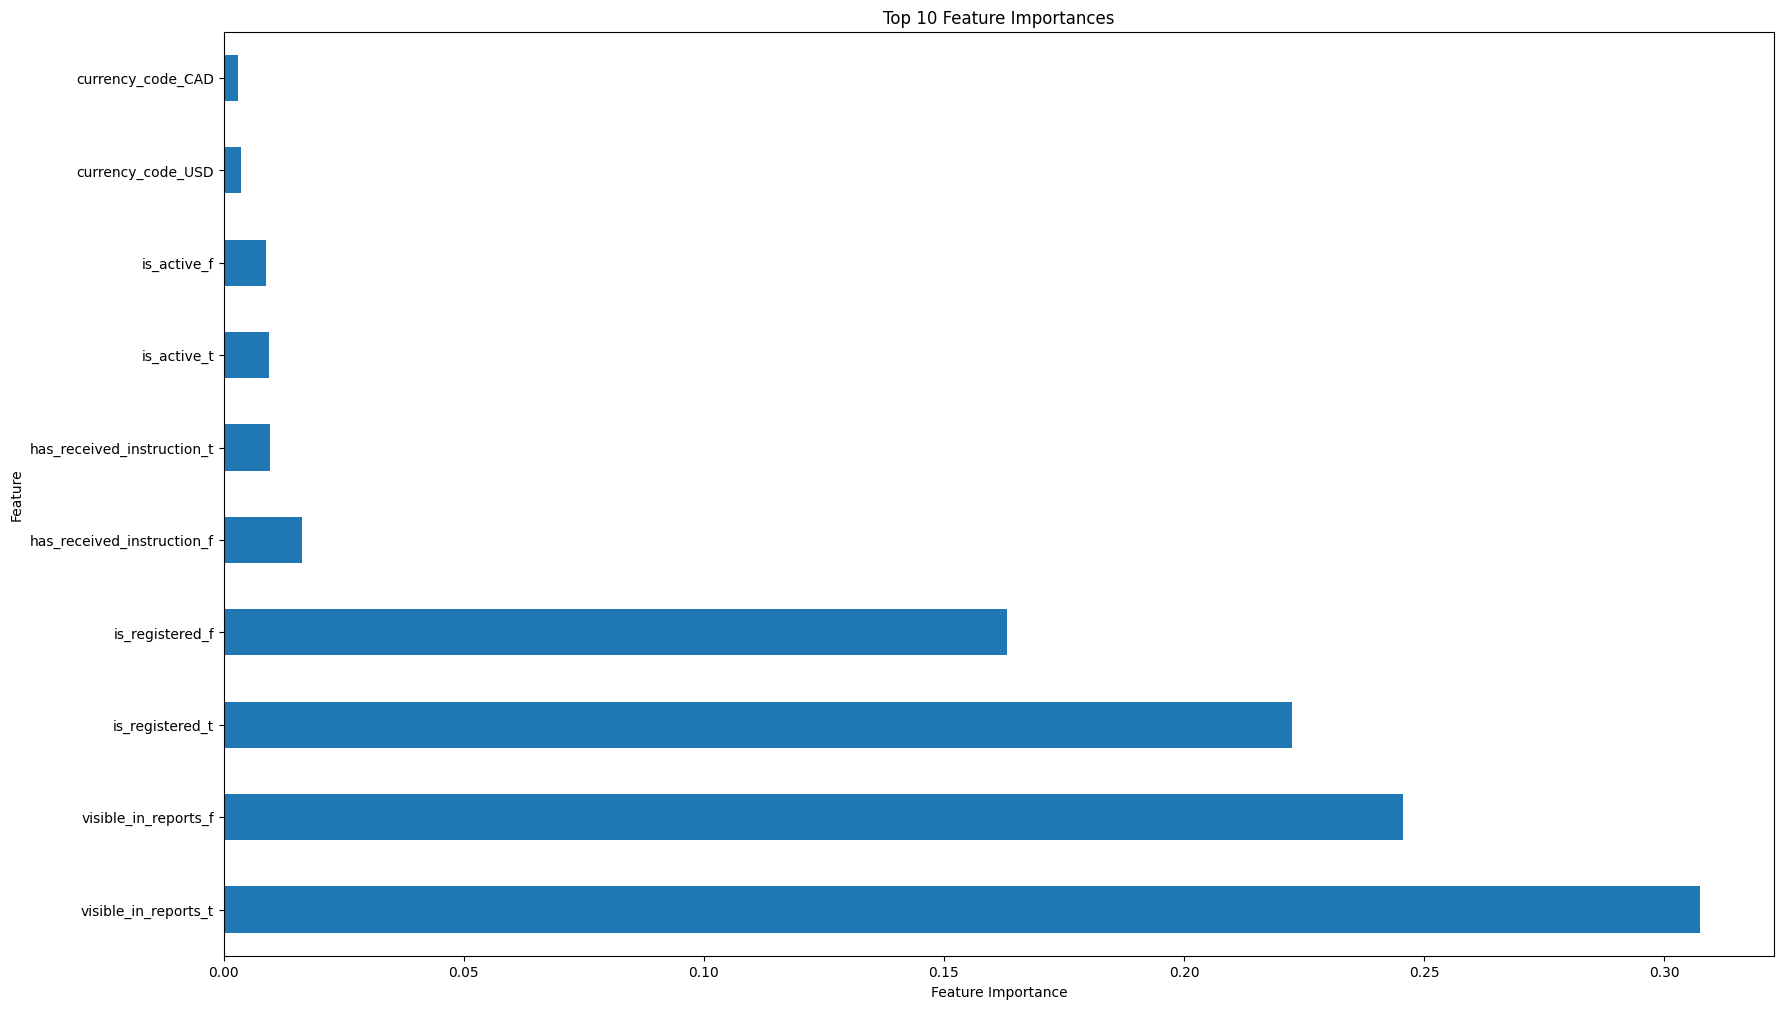

In [53]:
plt.figure(figsize=(20, 12))
feature_importances = pd.Series(no_nan_data_model.feature_importances_, index = no_nan_cols_no_time_series_dummies.columns)
feature_importances.nlargest(10).plot(kind='barh')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importances')
plt.show()

This simple Random Forest Classifier did a decent job. As we analyze using our domain knowledge, if a client is **not visible in reports**, it may indicate that the client has been inactive for a long time, leading to the churn decision of that client.

#### Evaluate the importance of each feature to the target

In [54]:
auc_scores = []
roc_curves = []

for feature in no_nan_cols_no_time_series_dummies.columns:
    _feature = no_nan_cols_no_time_series_dummies[[feature]]
    no_nan_data_model.fit(_feature, rf_label)
    
    y_pred = no_nan_data_model.predict_proba(_feature)[:, 1]
    
    fpr, tpr, _ = roc_curve(rf_label, y_pred)
    roc_curves.append((fpr, tpr))
    
    auc_score = auc(fpr, tpr)
    auc_scores.append(auc_score)

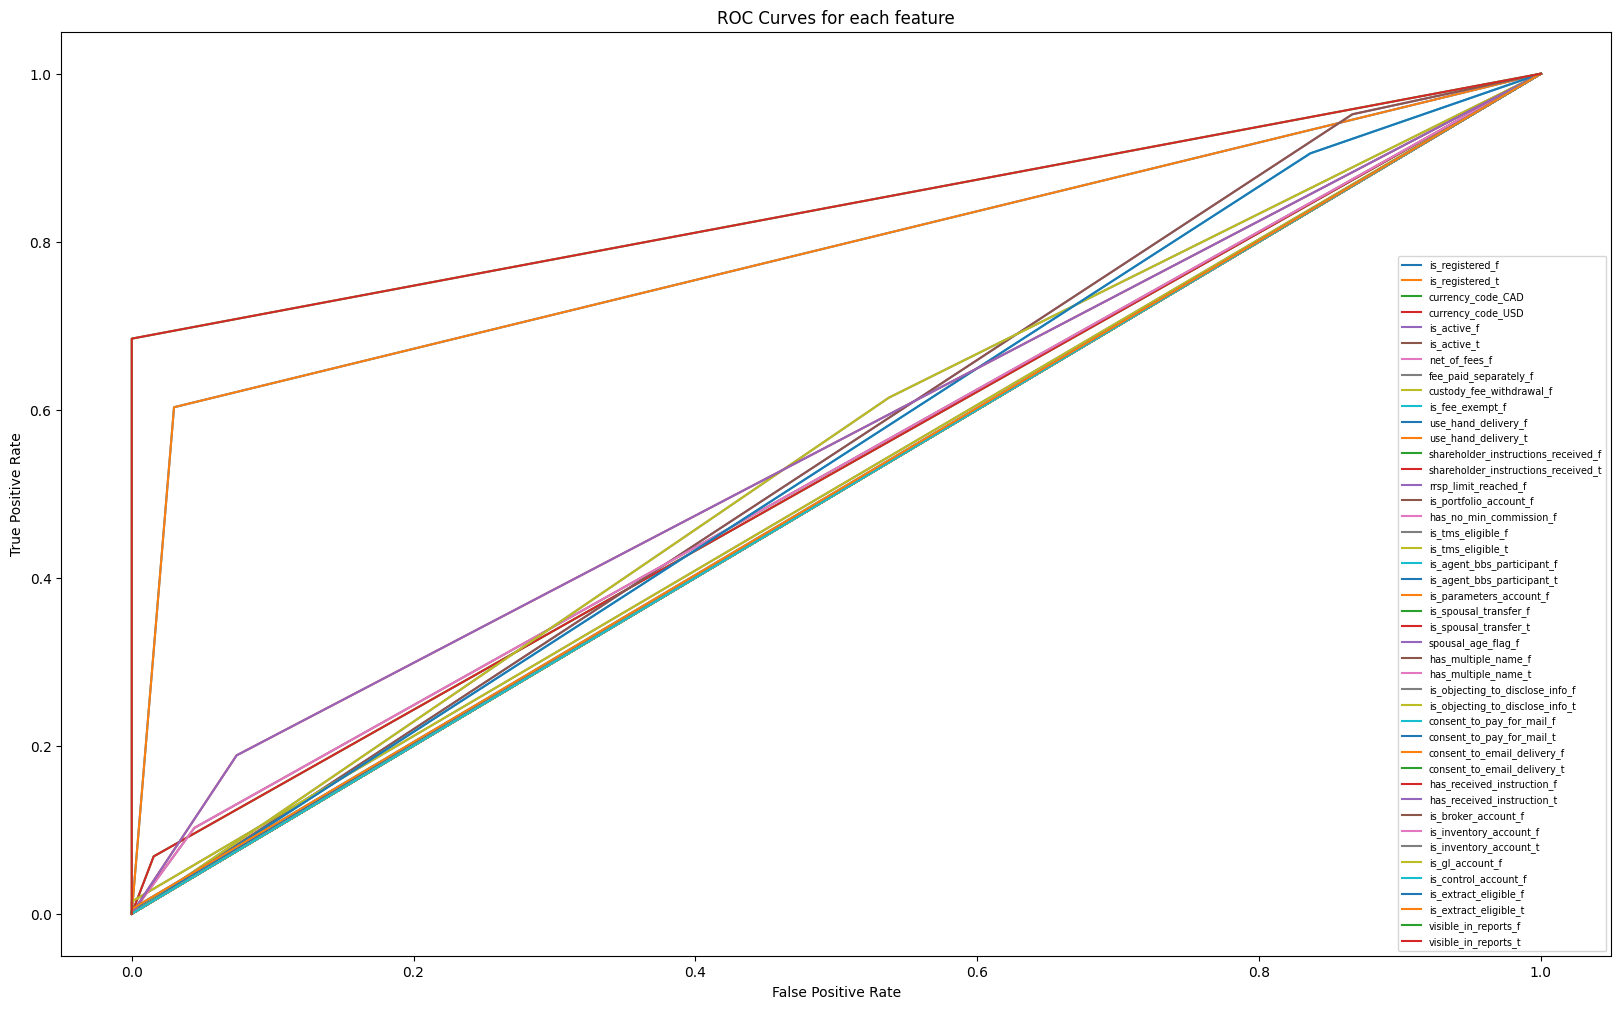

In [55]:
plt.figure(figsize=(20, 12))
for fpr, tpr in roc_curves:
    plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for each feature')
plt.legend(no_nan_cols_no_time_series_dummies.columns, loc='lower right', fontsize='x-small')
plt.show()

In [56]:
# print AUC score for each feature
for i, feature in enumerate(no_nan_cols_no_time_series_dummies.columns):
    print(f"Feature '{feature}': AUC = {auc_scores[i]}")

Feature 'is_registered_f': AUC = 0.7864644294739092
Feature 'is_registered_t': AUC = 0.7864644294739092
Feature 'currency_code_CAD': AUC = 0.526330192205018
Feature 'currency_code_USD': AUC = 0.526330192205018
Feature 'is_active_f': AUC = 0.5427176541179999
Feature 'is_active_t': AUC = 0.5427176541179999
Feature 'net_of_fees_f': AUC = 0.5
Feature 'fee_paid_separately_f': AUC = 0.5
Feature 'custody_fee_withdrawal_f': AUC = 0.5
Feature 'is_fee_exempt_f': AUC = 0.5
Feature 'use_hand_delivery_f': AUC = 0.5000130317038161
Feature 'use_hand_delivery_t': AUC = 0.5000130317038161
Feature 'shareholder_instructions_received_f': AUC = 0.5003157166115435
Feature 'shareholder_instructions_received_t': AUC = 0.5003157166115435
Feature 'rrsp_limit_reached_f': AUC = 0.5
Feature 'is_portfolio_account_f': AUC = 0.5
Feature 'has_no_min_commission_f': AUC = 0.5
Feature 'is_tms_eligible_f': AUC = 0.5071957343753483
Feature 'is_tms_eligible_t': AUC = 0.5071957343753483
Feature 'is_agent_bbs_participant_f': 

Question: Should we drop features based solely on AUC score of each feature?

In [57]:
#### Rule of thumb for "good" AUC score

# Each feature with an AUC score above 0.7 would be considered acceptable, therefore any features with AUC score < 0.7 would be considered for removing.

# df_copy = df_copy.drop(['currency_code', 'is_active', 'net_of_fees', 'fee_paid_separately', 'custody_fee_withdrawal', 'is_fee_exempt', 'use_hand_delivery', 'shareholder_instructions_received', 
#                         'rrsp_limit_reached', 'is_portfolio_account', 'has_no_min_commission', 'is_tms_eligible', 'is_agent_bbs_participant', 'is_parameters_account', 'is_spousal_transfer', 
#                         'spousal_age_flag', 'has_multiple_name', 'is_objecting_to_disclose_info', 'consent_to_pay_for_mail', 'consent_to_email_delivery', 'has_received_instruction', 'is_broker_account', 
#                         'is_inventory_account', 'is_gl_account', 'is_control_account', 'is_extract_eligible'], axis=1)

In [58]:
# no_nan_cols_no_time_series_dummies = no_nan_cols_no_time_series_dummies.drop(['currency_code_CAD', 'currency_code_USD', 'is_active_f', 'is_active_t', 'net_of_fees_f',
#                                                                               'fee_paid_separately_f', 'custody_fee_withdrawal_f', 'is_fee_exempt_f', 
#                                                                               'use_hand_delivery_f', 'use_hand_delivery_t', 'shareholder_instructions_received_f', 'shareholder_instructions_received_t',
#                                                                               'rrsp_limit_reached_f', 'is_portfolio_account_f', 'has_no_min_commission_f',
#                                                                               'is_tms_eligible_f', 'is_tms_eligible_t', 'is_agent_bbs_participant_f', 'is_agent_bbs_participant_t', 'is_parameters_account_f',
#                                                                               'is_spousal_transfer_f', 'is_spousal_transfer_t', 'spousal_age_flag_f', 'has_multiple_name_f', 'has_multiple_name_t',
#                                                                               'is_objecting_to_disclose_info_f', 'is_objecting_to_disclose_info_t', 'consent_to_pay_for_mail_f', 'consent_to_pay_for_mail_t',
#                                                                               'consent_to_email_delivery_f', 'consent_to_email_delivery_t', 'has_received_instruction_f', 'has_received_instruction_t',
#                                                                               'is_broker_account_f', 'is_inventory_account_f', 'is_inventory_account_t', 'is_gl_account_f',
#                                                                               'is_control_account_f', 'is_extract_eligible_f', 'is_extract_eligible_t'], axis=1)

In [59]:
no_nan_cols_no_time_series_dummies

,is_registered_f,is_registered_t,currency_code_CAD,currency_code_USD,is_active_f,is_active_t,net_of_fees_f,fee_paid_separately_f,custody_fee_withdrawal_f,is_fee_exempt_f,use_hand_delivery_f,use_hand_delivery_t,shareholder_instructions_received_f,shareholder_instructions_received_t,rrsp_limit_reached_f,is_portfolio_account_f,has_no_min_commission_f,is_tms_eligible_f,is_tms_eligible_t,is_agent_bbs_participant_f,is_agent_bbs_participant_t,is_parameters_account_f,is_spousal_transfer_f,is_spousal_transfer_t,spousal_age_flag_f,has_multiple_name_f,has_multiple_name_t,is_objecting_to_disclose_info_f,is_objecting_to_disclose_info_t,consent_to_pay_for_mail_f,consent_to_pay_for_mail_t,consent_to_email_delivery_f,consent_to_email_delivery_t,has_received_instruction_f,has_received_instruction_t,is_broker_account_f,is_inventory_account_f,is_inventory_account_t,is_gl_account_f,is_control_account_f,is_extract_eligible_f,is_extract_eligible_t,visible_in_reports_f,visible_in_reports_t
0,True,False,True,False,False,True,True,True,True,True,True,False,True,False,True,True,True,True,False,True,False,True,True,False,True,True,False,True,False,True,False,True,False,True,False,True,True,False,True,True,False,True,True,False
1,False,True,True,False,False,True,True,True,True,True,True,False,True,False,True,True,True,True,False,True,False,True,True,False,True,True,False,True,False,True,False,True,False,False,True,True,True,False,True,True,False,True,False,True
2,False,True,True,False,False,True,True,True,True,True,True,False,True,False,True,True,True,True,False,True,False,True,True,False,True,True,False,False,True,False,True,True,False,False,True,True,True,False,True,True,False,True,True,False
3,True,False,True,False,False,True,True,True,True,True,True,False,True,False,True,True,True,True,False,True,False,True,True,False,True,True,False,True,False,True,False,True,False,False,True,True,True,False,True,True,False,True,False,True
4,True,False,True,False,False,True,True,True,True,True,True,False,True,False,True,True,True,True,False,True,False,True,True,False,True,True,False,False,True,True,False,True,False,False,True,True,True,False,True,True,False,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
673334,False,True,True,False,False,True,True,True,True,True,True,False,True,False,True,True,True,True,False,True,False,True,True,False,True,True,False,True,False,True,False,True,False,False,True,True,True,False,True,True,False,True,False,True
673335,False,True,True,False,True,False,True,True,True,True,True,False,True,False,True,True,True,True,False,True,False,True,True,False,True,True,False,True,False,True,False,True,False,False,True,True,True,False,True,True,False,True,True,False
673336,True,False,True,False,False,True,True,True,True,True,True,False,True,False,True,True,True,True,False,True,False,True,True,False,True,False,True,False,True,False,True,True,False,False,True,True,True,False,True,True,False,True,False,True
673337,False,True,True,False,False,True,True,True,True,True,True,False,True,False,True,True,True,True,False,True,False,True,True,False,True,True,False,False,True,True,False,True,False,False,True,True,True,False,True,True,False,True,False,True


As clustering on the above data would cause huge time complexity and resources, we have to perform some dimensionality reduction techniques such as PCA to extract new set of features that bring most variance (retain the original information) of our dataset.

### PCA

In [60]:
no_nan_cols_dummies_train = np.array(no_nan_cols_no_time_series_dummies).astype(np.float32)

In [61]:
no_nan_cols_dummies_train

array([[1., 0., 1., ..., 1., 1., 0.],
       [0., 1., 1., ..., 1., 0., 1.],
       [0., 1., 1., ..., 1., 1., 0.],
       ...,
       [1., 0., 1., ..., 1., 0., 1.],
       [0., 1., 1., ..., 1., 0., 1.],
       [1., 0., 1., ..., 1., 1., 0.]], dtype=float32)

In [62]:
cov_mat = np.cov(no_nan_cols_dummies_train.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

print(f"Eigenvalues: \n {eigen_vals}")
print(f"Eigenvalues shape: {eigen_vals.shape}")

Eigenvalues: 
 [ 6.84846730e-01+0.00000000e+00j  5.08441652e-01+0.00000000e+00j
  4.60265278e-01+0.00000000e+00j  1.92887068e-01+0.00000000e+00j
  1.51307440e-01+0.00000000e+00j  1.40998398e-01+0.00000000e+00j
  1.01926758e-01+0.00000000e+00j  1.02606643e-01+0.00000000e+00j
  2.22579684e-02+0.00000000e+00j  9.46238623e-03+0.00000000e+00j
  5.97636865e-03+0.00000000e+00j  3.48047384e-03+0.00000000e+00j
  4.42210839e-04+0.00000000e+00j  3.67973611e-04+0.00000000e+00j
  3.05345905e-04+0.00000000e+00j  9.92686318e-05+0.00000000e+00j
 -8.97755503e-18+1.51656694e-17j -8.97755503e-18-1.51656694e-17j
  1.39218458e-17+0.00000000e+00j -1.26362009e-18+1.79900133e-18j
 -1.26362009e-18-1.79900133e-18j  1.87878340e-18+7.42925052e-19j
  1.87878340e-18-7.42925052e-19j -1.26951048e-18+0.00000000e+00j
  1.01444321e-18+0.00000000e+00j -5.18112782e-19+0.00000000e+00j
 -3.88409724e-19+0.00000000e+00j  1.75361396e-19+0.00000000e+00j
  1.19050461e-19+0.00000000e+00j  4.73672514e-20+0.00000000e+00j
 -3.449358

In [63]:
def explain_variance(eigenvalues):
    '''
        Plot how many PCA axes needed to explain most variance
        from the original feature space of our dataset
    '''
    var_explained = []
    total = sum(eigenvalues)
    for i in sorted(eigenvalues, reverse=True):
        var = i / total
        var_explained.append(var)
    cummulative_var_explained = np.cumsum(var_explained)
    plt.bar(range(1, len(eigenvalues)+1), var_explained, alpha=0.5, align='center', label='Individual explained variance ratio')
    plt.step(range(1, len(eigenvalues)+1), cummulative_var_explained, where='mid', label='Cummulative explained ratio')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal component index')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

/opt/conda/lib/python3.10/site-packages/matplotlib/transforms.py:762: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)
/opt/conda/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


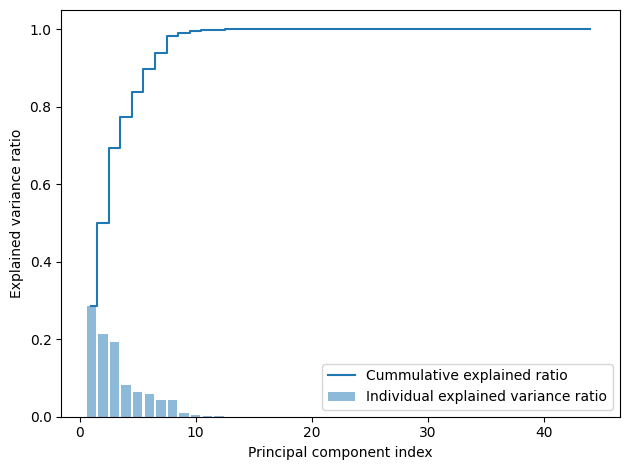

In [64]:
explain_variance(eigen_vals)

As we can see, with the number of PCA axes of 10 axes, they already explained almost 100% of the variance of the original data. We will pick 10 as the number of clusters for our SBM disussed later on.

Since the objective is to classify whether a user churned or didn't churn from the service, so we have to drop the plan_end_date column.

In [65]:
df_copy = df_copy.drop('plan_end_date', axis=1)

In [66]:
df_copy

,id,type_code,is_registered,currency_code,is_active,class_id,debit_code,last_trade_date,contract_type,inception_date,net_of_fees,fee_paid_separately,custody_fee_withdrawal,is_fee_exempt,branch,credit_limit_type,retail_plan,is_spousal,is_arp_locked,arp_pension_origin,language_code,dividend_confirm_code,sss_location,options_trading_type,sss_type,sss_agent,is_midwest_clearing_account,rep_commission_rate,rep_commission_override,interest_dividend_conversion_type,guarantee_gtor_type,use_hand_delivery,shareholder_instructions_received,rrsp_limit_reached,is_portfolio_account,has_no_min_commission,is_tms_eligible,is_agent_bbs_participant,is_parameters_account,is_spousal_transfer,spousal_age_flag,terminal_code,has_multiple_name,deceased_fair_market_value,target_grantor_grantee_flag,discretionary_trading_authorized,iso_funds_code,shareholder_language,dup_trip_quad_code,special_tag,conjunction,title,function_code,tms_settlement_location,portfolio_cost_method,portfolio_name_address_option,portfolio_report_option,portfolio_summary_option,loan_limit_override,interactive_portfolio_code,non_plan_book_value_flag,has_discrete_auth,last_update_date,is_objecting_to_disclose_info,mailing_consent,consent_to_pay_for_mail,consent_to_email_delivery,has_received_instruction,risk_tolerance,investment_objective,is_broker_account,is_inventory_account,is_gl_account,is_control_account,is_extract_eligible,last_maintenance_time,last_maintenance_user,is_pledged,special_fee_code,non_calendar_year_end,plan_effective_date,is_resp,number_of_beneficiaries,rrif_original_date,use_original_date_for_payment_calc,is_family_resp,is_hrdc_resp,is_plan_grandfathered,resp_specimen_plan,inserted_at,updated_at,retail_last_maintenance_time,retail_last_maintenance_user,visible_in_reports,label
0,893724,CASH SWEEP,f,CAD,t,3.0,0,NaN,NaN,2017-08-18,f,f,f,f,IAVM,0.0,NaN,NaN,NaN,NaN,E,0.0,NaN,0.0,NaN,NaN,False,0.0,0.0,0.0,0.0,f,f,f,f,f,f,f,f,f,f,NaN,f,0.0,NaN,f,CAD,NaN,A,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,0.0,V,f,NaN,f,0.0,f,f,f,NaN,NaN,f,f,f,f,t,2021-12-16 00:00:00,T80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-05-30 14:20:18.531115+00,2023-08-08 18:53:01.439561+00,NaN,NaN,f,Churn
1,1268094,RRIF,t,CAD,t,5.0,C,2022-07-04,18.0,2018-11-08,f,f,f,f,IAVM,0.0,RI,f,f,NaN,E,0.0,NaN,0.0,NaN,NaN,False,0.0,0.0,0.0,2.0,f,f,f,f,f,f,f,f,f,f,BATCH,f,0.0,NaN,f,CAD,NaN,A,NaN,NaN,MR,NaN,NaN,0.0,0.0,0.0,0.0,NaN,0.0,NaN,f,2022-09-08,f,0.0,f,f,t,H10M90,B05G85S10,f,f,f,f,t,2023-01-03 00:00:00,BATCH,f,NaN,0000,2018-11-08,f,0.0,2018-11-08,f,f,f,f,NaN,2023-05-30 14:20:18.531115+00,2023-08-10 21:47:25.370403+00,2023-01-03 00:00:00,BATCH,t,Churn
2,606613,SPOUSAL RRSP,t,CAD,t,5.0,A,2018-07-05,16.0,2009-04-08,f,f,f,f,IAVM,0.0,RS,t,f,NaN,F,0.0,NaN,0.0,NaN,NaN,False,0.0,0.0,0.0,2.0,f,f,f,f,f,f,f,f,f,f,G023,f,0.0,NaN,f,CAD,F,A,NaN,NaN,MADAME,NaN,NaN,0.0,0.0,0.0,0.0,NaN,0.0,NaN,f,2014-04-23,t,0.0,t,f,t,H50M50S00,G50S50,f,f,f,f,t,2021-03-15 00:00:00,GUERINO,f,NaN,00/0,2009-04-08,f,0.0,2009-04-08,f,f,f,f,NaN,2023-05-30 14:20:18.531115+00,2023-08-10 21:47:25.370403+00,2018-07-17 00:00:00,GUERINO,f,Churn
3,741930,CASH,f,CAD,t,3.0,T,NaN,12.0,2021-01-04,f,f,f,f,IAVM,0.0,NaN,NaN,NaN,NaN,E,0.0,NaN,0.0,NaN,NaN,False,0.0,0.0,0.0,0.0,f,f,f,f,f,f,f,f,f,f,113C,f,0.0,NaN,f,CAD,NaN,A,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,0.0,V,f,2021-01-04,f,0.0,f,f,t,M99,G99,f,f,f,f,t,2021-01-04 00:00:00,T80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-05-30 14:20:18.531115+00,2023-08-08 18:53:01.439561+00,NaN,NaN,t,Churn
4,1137922,CASH,f,CAD,t,3.0,T,NaN,17.0,2017-07-21,f,f,f,f,IAVM,0.0,NaN,NaN,NaN,NaN,E,0.0,NaN,0.0,NaN,NaN,False,0.0,0.0,0.0,0.0,f,f,f,f,f,f,f,f,f,f,BATCH,f,0.0,NaN,f,CAD,NaN,A,NaN,NaN,MRS,NaN,NaN,0.0,0.0,0.0,0.0,NaN,0.0,V,NaN,2017-07-24,t,0.0,f,f,t,M99,G99,f,f,f,f,t,2023-06-27 00:00:00,H01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-05-30 14:20:18.531115+00,2023-08-08 20:52:08.352646+00,NaN,NaN,f,Churn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

We have extracted 10 PCA axes as the ideal number of clusters for our clustering algorithm for the non-null dataset.

In [ ]:
# cluster the data with the number of clusters = 10
optimal_num_clusters = 10
kmode_optimal = KModes(n_clusters = optimal_num_clusters, init = 'Cao', n_init = 1, verbose = 1)          # applied K-modes clustering for categorical data
clusters = kmode_optimal.fit_predict(no_nan_cols_no_time_series_dummies)

Init: initializing centroids
Init: initializing clusters
Starting iterations...


In [ ]:
np.unique(clusters)             # 10 unique clusters

In [ ]:
df_copy['Clusters'] = clusters

In [ ]:
df_copy

In [ ]:
# check if all records per cluster add up to the original number of records
rec_count = 0
for i in range(len(np.unique(clusters))):
    rec_count = rec_count + len(df_copy.loc[df_copy['Clusters'] == i])

In [ ]:
rec_count

### Filling missing values
Each record in our original dataset (containing null values) has been assigned to each of the 10 clusters. We proceed with filling null values by the mode of each column corresponding to each null value and the cluster number.

In [ ]:
# if the cluster is 0, then loop over every column within each record corresponding to cluster 0. The same thing with other clusters
def fill_nan_by_mode(data, cluster_col):
    '''
        Fill null values by the mode of each column
        corresponding to each null value and cluster number
        
        data: DataFrame
        cluster_col: name of the cluster column
    '''
    for cluster_num in data[cluster_col].unique():
        cluster_data = data[data[cluster_col] == cluster_num]
        
        # fill null values with mode for each cluster
        cluster_mode = cluster_data.mode().iloc[0]       # select the first row and calculate the mode for each column in DataFrame, the result is that row containing the mode value of each column
        data.loc[data[cluster_col] == cluster_num] = data.loc[data[cluster_col] == cluster_num].fillna(cluster_mode)
    return data

In [ ]:
# # experimenting filling missing values by mode without considering the cluster
# def fill_nan_by_mode_no_clusters(data, cluster_col):
#     for col in data.columns:
#         cluster_mode = data[col].mode()[0]
#         data[col] = data[col].fillna(cluster_mode)
#     return data

In [ ]:
df_copy = fill_nan_by_mode(df_copy, 'Clusters')

In [ ]:
# df_copy_3 = fill_nan_by_mode_no_clusters(df_copy_3, 'Clusters')

In [ ]:
# df_copy_3   # this only fill the missing values of each column with its mode, which will cause bias for our model -> the method of filling missing values with mode of the column based on cluster works better

In [ ]:
# print the number of null values for each column for df_copy2
for col in df_copy.columns:
    print(f"'{col}' nulls: {df_copy[col].isna().sum()}")

There are a lot of columns missing 7427 values, so we suspect that there are 7427 rows that contain missing values in those columns. Observe that there is 'tms_settlement_location' containing 186399 null values which take up a lot of our data, so we might consider dropping that column. After checking the description of this column, the settlement location doesn't really determine the churn behavior of a client (there are features that have stronger relationship to the churn behavior), thus we drop 'tms_settlement_location'. Also, for columns that contain less than 100000 null values, we will drop those null values since they aren't a huge part of our dataset. We perform these methods, then rerun the loop above to check for null values in each column.

In [ ]:
for col in df_copy.columns:
    if df_copy[col].isna().sum() < 100000:
        df_copy.dropna(subset=[col], inplace=True)

In [ ]:
df_copy = df_copy.drop('tms_settlement_location', axis=1)

In [ ]:
df_copy          # clean df_copy, dataset contains 0 null values

In [ ]:
# print the number of null values for each column for df_copy2
for col in df_copy.columns:
    print(f"'{col}' nulls: {df_copy[col].isna().sum()}")

Each client has a unique ID, but since the default index column in pandas contains unique indices as well for each record (client), we should drop the 'id' column to reduce the dimension of the encoded dataset later on, as every value in the ID column is unique so there will be many categories when decoding.

In [ ]:
df_copy = df_copy.drop('id', axis=1)

In [ ]:
df_copy.reset_index(drop=True, inplace=True)

In [ ]:
df_copy = df_copy.drop(['plan_effective_date'], axis=1)                                  # drop plan_effective_date, since inception_date dates come first
df_copy_time_based_cols = df_copy_time_based_cols.drop(['plan_end_date', 'plan_effective_date'], axis=1)

In [ ]:
# convert date time to just year month day
for col in df_copy_time_based_cols.columns:
    df_copy[col] = pd.to_datetime(df_copy[col])

In [ ]:
df_copy

In [ ]:
# get the label column to assign to target outcome later on
label_ = df_copy['label']

In [ ]:
df_copy = df_copy.drop(['label', 'Clusters'], axis=1)

In [ ]:
# check the number of categories per column
total_categories = 0
for col in df_copy.columns:
    print(f"Number of categories in '{col}': {len(df_copy[col].unique())}")
    total_categories += len(df_copy[col].unique())
print(f"Total number of categories: {total_categories}")

### Encoding dataset: Binary encoding
There are time-series features that contain a lot of different categories (time, hour). If we chose to perform one-hot encoding, it may cause a very large dataset and there will not be enough memory. Binary Encoding is the alternative.

In [ ]:
binary_encoder = ce.BinaryEncoder(cols=list(df_copy.columns), return_df=True)

In [ ]:
df_copy_encoded = binary_encoder.fit_transform(df_copy)
df_copy_encoded    # encode df_copy

In [ ]:
# correlation between features
corr_matrix_ = df_copy_encoded.corr()
corr_matrix_

### Correlations between pairs of features that exceed the correlation threshold

In [ ]:
corr_thresh_ = 0.7

corr_pairs_ = []
for i in range(len(corr_matrix_.columns)):
    for j in range(i+1, len(corr_matrix_.columns)):
        if abs(corr_matrix_.iloc[i, j] > corr_thresh_):
            corr_pairs_.append((corr_matrix_.columns[i], corr_matrix_.columns[j], corr_matrix_.iloc[i, j]))

for pair in corr_pairs_:
    print(f"Features '{pair[0]}' and '{pair[1]}' have correlation of: '{pair[2]}'")

In [ ]:
df_copy_encoded

In [ ]:
corr_thresh_ = 0.7

corr_pairs_ = []
corr_hash = {}

for i in range(len(corr_matrix_.columns)):
    for j in range(i+1, len(corr_matrix_.columns)):
        if abs(corr_matrix_.iloc[i, j] > corr_thresh_):
            corr_pairs_.append((corr_matrix_.columns[i], corr_matrix_.columns[j], corr_matrix_.iloc[i, j]))
            # if a feature appears at least 2 times when having high correlation with other features -> drop such features
            if corr_matrix_.columns[i] in corr_hash:
                df_copy_encoded = df_copy_encoded.drop(corr_matrix_.columns[i], axis=1)
                break
            else:
                corr_hash[corr_matrix_.columns[i]] = corr_matrix_.iloc[i, j]

In [ ]:
df_copy_encoded

### MCA: Reduce the dimension for categorical data

In [ ]:
df_copy_encoded = df_copy_encoded.drop('label', axis=1)

In [ ]:
# init MCA
mca = prince.MCA(n_components=3, n_iter=3, copy=True, check_input=True, engine='sklearn', random_state=42)

In [ ]:
# fit MCA to our encoded data
mca.fit(df_copy_encoded)

In [ ]:
# transform df_copy_encoded to the MCA version
df_copy_encoded_mca = mca.transform(df_copy_encoded)

In [ ]:
# extract the eigenvalues -> see the cummulative variance explained -> pick the number of components that explain enough variance for our data
mca.eigenvalues_summary

In [ ]:
# visualization
mca.plot(df_copy_encoded, x_component=0, y_component=1, show_column_markers=True, show_row_markers=True, show_column_labels=False, show_row_labels=False)

In [ ]:
# # visualization
# fig, ax = plt.subplots(figsize=(10, 7))
# ax.scatter(df_copy_encoded_mca_[0], df_copy_encoded_mca_[1], c='blue', edgecolors='k', alpha=0.5)
# ax.set_xlabel('Dimension 1')
# ax.set_ylabel('Dimension 2')
# ax.set_title('MCA results')
# plt.axhline(0, color='grey', lw=1)
# plt.axvline(0, color='grey', lw=1)
# plt.grid(True)
# plt.show()

## Preparing data for model training

In [ ]:
def binary_to_numeric(value):
    '''
        Convert "Churn" to 1
        and "No Churn" to 0
    '''
    if value == "Churn":
        return 1
    elif value == "No Churn":
        return 0
    else:
        return None

In [ ]:
# target outcome
y_ = label_.apply(binary_to_numeric)

In [ ]:
y_

In [ ]:
df_copy_encoded['label'] = y_

In [ ]:
df_copy_train, df_ = train_test_split(df_copy_encoded, test_size=0.40, random_state=1)
df_copy_cv, df_copy_test = train_test_split(df_, test_size=0.50, random_state=1)

del df_

X_train = df_copy_train.drop('label', axis=1)
y_train = df_copy_train['label']

X_cv = df_copy_cv.drop('label', axis=1)
y_cv = df_copy_cv['label']

X_test = df_copy_test.drop('label', axis=1)
y_test = df_copy_test['label']

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_cv shape: {X_cv.shape}")
print(f"y_cv shape: {y_cv.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

In [ ]:
X_train = np.array(X_train).astype(np.float32)
y_train = np.array(y_train).astype(np.float32)

X_cv = np.array(X_cv).astype(np.float32)
y_cv = np.array(y_cv).astype(np.float32)

X_test = np.array(X_test).astype(np.float32)
y_test = np.array(y_test).astype(np.float32)

## Modeling:

After getting exhausted with processing data, we are confident to perform a model to examine the churn behavior of each client, thus classify each client into churn or no churn. We will present a fairly unique model that captures the behavior of each client, how each client actually relates to each other. That is the Social Network Analysis, utilizing the Stochastic Block Model (SBM).

### Stochastic Block Model (SBM)

#### Predictive Modeling (for Churn classification and Marketing Strategies to Maximize Likelihood of Staying)
SBM can predict missing or future connections in networks, and forecast node attributes based on their network position and block memberships.

#### Network Analysis
It's a statistical framework used to analyze networks by partitioning nodes (customers) into blocks (clusters) based on theier connectivity (relationship) patterns. It assumes that nodes within the same block have similar interaction probabilities, while interaction probabilities between nodes in different blocks are governed by different parameters. In the context of SBM, the adjacency matrix is analyzed to identify the blocks or segments of customers. These blocks represent groups of customers who interact with each other more frequently than with customers outside their block. The identification of blocks can be achieved through various clustering algorithms that are designed to work with SBM. SBM estimates the probabilities of interactions between and within these blocks
* A high probability of interaction within a block but low between blocks might indicate a strong community effect that can be significant for marketing strategies

* Notice there are 2 blocks that don't have mutual connection, because the block label is the negation of each other.
* There are blocks that have connections ('like apples hate grapes' and 'like oranges hate grapes'), because these 2 blocks both hate grapes
* Generally, the probability of edges (connections) between nodes within the same block is higher than that of between blocks, which makes intuitive sense
* Each edge represents the likelihood of an edge (connection) existing between pairs of nodes in the network
* The edge probabilities can vary depending on whether the nodes belong to the same block (within-block edges) or different block (between-block edges)

##### Within-block edge probability
* Within-block edge probabilities are denoted by p_in

##### Between-block edge probability
* Between-block edge probabilities are denoted by p_out

##### Probability distribution
* Edge probabilities in an SBM are modeled using Bernoulli distributions due to the binary nature (either an edge exists or it doesn't)
* Given a pair of nodes, the probability of an edge existing between them follows a Bernoulli distribution

* p is the probability of success
* x is the binary outcome variable (0 or 1, representing the absence or presence of an edge)
* if a random number drawn from this distribution is less than or equal to p (p_in or p_out), an edge is considered to exist between the nodes, otherwise, there is no edge

##### Edge modeling
* Edge probabilities in SBM are typically estimated from the observed network data using MLE or Bayesian inference
* These probabilities capture the underlying structure of the network (community structures, connectivity patterns, relationship strengths)

### Why SBM?
While we were at the stage of processing customer data, we believed that each client within a company, even though they don't know each other, they may likely give off the same churn behavior based on some features on our data.

* Each block is a group of customers with similar behaviors, preferences, or interaction patterns. Customers within the same block are more likely to exhibit similar churn behaviors compared to those in different blocks
* Customers who are more connected within the network might be less likely to churn due to stronger tie or social influence, word-of-mouth effect, etc.
* Customers who frequently use complementary products within the same network might exhibit lower churn rates, due to increased product stickiness and statisfaction.

### Determine the optimal number of blocks (block size), the probability of an edge existing between nodes within each cluster, and the probability of an edge existing between clusters
* Denote probability of an edge existing between nodes within each cluster: p_in
* Denote probability of an edge existing between clusters: p_out

To determine the optimal number of those, we follow the following steps: 
1. Perform PCA for dimensionality reduction over our dataset so that we can extract the most important features
2. Perform clustering (K-means, K-modes, etc) to cluster the dimensionality reduced dataset
3. Visualize and get the number of clusters, and use the number for the initial number of blocks of our SBM
4. Determine the optimal p_in by similarity metric and p_out by dissimilarity metric: Within-cluster similarity can provide insights to strength of connections within blocks. Between-clusters dissimilarity can provide insights to separations between blocks.
5. We can get the optimal p_in and p_out by MLE by: Calculate the average similarity (edge) within each cluster and assign to p_in. Calculate the average dissimilarity (edge) between clusters and assign to p_out.

Decoding `investment_objective` data:

Similar to `risk_tolerance`, for `investment_objective`, the alphanumeric digit indicates the type of security associated with each client, and the number next to each type indicates the probability of having that type of security for each client.

#### Determine the feature importance for: Features to determine the connection between blocks, and features to determine the connection between nodes within each block
* More important features will be used to determine the segmentation of blocks
* Less important features will be used to determine the segmentation of nodes within each block

#### Strategy development
* If certain blocks of customers are identified as high risk for churn, specific strategies can be designed for these blocks
* Understanding the interaction patterns can help in devising referral programs, **cross-selling strategies** and personalized marketing campaigns that leverage the network effects within and across customer blocks